# Классификация
__Классификация__ - одна из самых важных форм предсказания: ее цель состоит в том, чтобы предсказать является ли запись 0 или 1 (купит/не купит, нажмет/не нажмет и пр.), либо в некоторых случаях одной из категорий (например,фильтрация входящих сообшений на почте - "основные", "спам", "соцсети" и т.д.). В случае, когда имеется более двух исходов, задачу часто можно преобразовать в серию двоичных задач с использованием условных вероятнстей. Например, по окончании действия договора, может быть 3 исхода:<br>
* $Y=0$ - клиент заключает новый долгосрочный договор<br>
* $Y=1$ - клиент переходит на оплату по месяцам<br>
* $Y=2$ - уходит к другому поставщику<br>

Т.е. чтобы решить исходную задачу, можно решить две двоичные (с двумя исходами) задачи:
1. Предсказать, $Y=0$ или $Y>0$
1. Если $Y>0, Y=1$ или $Y=2$

С точки зрения подгонки модели часто выгодно конвертировать многоклассовую задачу в серию двоичных задач. В особенности это актуально, когда одна категория распространена намного больше, чем другие категории.

### Наивный Байес
Наивный байесов алгоритм использует вероятность наблюдать значения предсказательных переменных при наличии некого исхода, чтобы оценить то, что по настоящему интересует: вероятность наблюдать исход $Y$ при наличии множества значений предсказателей.

__Полная (точная) байесовская классификация__.<br>
Для каждой классифицируемой записи:
1. Отыскать все другие записи с одинаковым предсказательным профилем (т.е. в которых значения предикторов одинаковы)
1. Определить к каким классам эти записи принадлежат и какой класс явл преобладающим (т.е. вероятным)
1. Назначить этот класс новой записи

`В стандартном байесовском подходе, все предикторы должны быть категориальными (факторными) переменными.` Точная байесовская классификация непрактична, т.к. если будет много предикторов, многие записи окажутся без точных совпадений.

### Наивное решение
В наивном решении, вычисление вероятности не ограничивается записями, которые совпадают с классифицируемой. Вместо этого используется весь набор данных.

* __Условная вероятность__ _(conditional probability)_ - вероятность наблюдать какое-то событие (скажем $X=i$) при условии, что имеется какое-то другое событие ($Y=i$); записывается как $P(X_i|Y_i)$.
* __Апостериорная вероятность__ _(posterior probability)_ - вероятность исхода после того, как предсказательная информация была учтена (в отличие от априорной вероятности исходов, которая ее не учитывает)
В наивном байесовом решении мы не ограничиваем вычисление вероятности теми записями, которые совпадают с классифицируемой. Вместо этого, используется весь набор данных:
1. Для двоичного отклика $Y=i$ ($i=0$ или $1$) оценить индивидуальные условные вероятности по каждому предсказателю $P(X_j|Y=i)$; они представляют собой вероятности того, что значение предсказателя находится в записи, когда мы наблюдаем $Y=i$. Указанная вероятность оценивается долей значений $X_j$ среди $Y=i$ записей в тренировочном наборе.
1. Перемножить эти вероятности друг с другом, а затем на долю записей, принадлежащих $Y=i$.
1. Повторить шаги 1 и 2 для всех классов.
1. Оценить вероятность для исхода __i__, взяв значение, вычисленное на шаге 2 для класса __i__ и поделив его на сумму таких значений для всех классов.
1. Отнести запись к классу с самой высокой вероятностью для этого множества значений предсказателй.

Вероятность наблюдать исход $Y=i$ при наличии множества значений предсказателей $X_1, ..., X_p$:

$$
P(Y=i|X_1, ..., X_p) = \frac{P(Y=i)P(X_1,...X_p|Y=i)}{P(Y=0)P(X_1,...,X_p|Y=0)+P(Y=1)P(X_1,...,X_p|Y=1)}
$$

в соответствии с наивным байесовским допущением об условной независимости это уравнение преобразуется в:

$$
P(Y=i|X_1, ..., X_p) = \frac{P(Y=i)P(X_1|Y=i)...P(X_p|Y=i)}{P(Y=0)P(X_1|Y=0)...P(X_p|Y=0)+P(Y=1)P(X_1|Y=1)...P(X_p|Y=1)}
$$

Эта формула называется "наивной", т.к. мы приняли упрощающее допущение, что `точная условная вероятность` вектора значений предсказателей, при определенном исходе, достаточно хорошо оценивается произведением отдельных условных вероятностей $P(X_j|Y=i)$ и таким образом допускаем, что предсказательные переменные не зависят друг от друга. 

In [413]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Данные о заемах.

In [414]:
loan_data = pd.read_csv('/Users/ivankudravcev/Studying/Data/loan_data.csv.gz')
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [415]:
loan_data.dtypes

Unnamed: 0             int64
status                object
loan_amnt              int64
term                  object
annual_inc             int64
dti                  float64
payment_inc_ratio    float64
revol_bal              int64
revol_util           float64
purpose               object
home_ownership        object
delinq_2yrs_zero       int64
pub_rec_zero           int64
open_acc               int64
grade                float64
outcome               object
emp_length             int64
purpose_              object
home_                 object
emp_len_              object
borrower_score       float64
dtype: object

Для получения модели в Python можно воспользоваться классом `sklearn.naive_bayes.MultinomialNB` из пакета `scikit-learn`. Прежде чем выполнить подгонку модели, нам нужно конвертировать категориальные признаки в фиктивные переменные при помощи метода `pd.get_dummies()`. В качестве предсказываемой переменной будет `outcome`, которая может принять значения:
* default - означает не выплату
* paid off - означает что заем выплачен  

Условные вероятности из подогнанной модели можно получить при помощи функции `feature_log_prob_`.

In [416]:
# Преобразуем данные в категориальные
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True) # alpha - параметр сглаживания; 
                                                        # fit_prior-нужно ли изучать априорные вероятности класса или нет. 
naive_model.fit(X, y)

# Используем последнее значение данных для тестирования
new_loan = X.loc[146:146,:]
print(f'predicted class: {naive_model.predict(new_loan)[0]}')

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                            columns=naive_model.classes_)

print(probabilities)

conditional_probabilities = naive_model.feature_log_prob_ # условные вероятности

predicted class: default
    default  paid off
0  0.653696  0.346304


Полученная модель на примере последней записи предсказала исход: __default__, а также при помощи метода `predict_proba` получены вероятности классов. Наивный байесов классификатор известен тем, что он производит _смещенные_ оценки. Однако там, где целью является ранжирование записей согласно вероятности, что $Y=1$, несмещенные оценки вероятности не нужны, и наивный байесов классификатор производит хорошие результаты.

### Числовые предсказательные переменные
Байесов наивный классификатор работает только с категориальными предсказателями (например, с классификацией спама, где присутствие или отсутствие слов, фраз, символов и т.д. лежат в основе предсказательной задачи). Для применения наивного байесовского классификатора к числовым предсказателям д. б. принят один из 2 подходов:
* разложить на корзины и конвертировать числовые предсказатели в категориальные предсказатели и далее применить предыдущий алгоритм.
* использовать вероятностную модель - например, нормальное распределение - для оценки условной вероятности $P(X_j|Y=i)$.

### Дискриминантный анализ
Это самый ранний статистический классификатор; он был представлен Фишером в 1936г. Охватывает несколько технических приемов, но самое широкое распространение получил _линейный дискриминантный анализ_ (Linear Discriminant Analysis, LDA). Сегодня LDA используется менее широко с появлениям древесных моделей и логистической регрессии. Однако, его можно встретить в некоторых приложениях и он имеет связи с другими более широко используемыми методами (например, анализ главных компонент). 
Не путать с латентным размещением Дирихле (Latent Dirichlet Allocation, LDA).

__Ковариация__ _(covariance)_ - мера степени, с которой переменная варьируется совместно с другой (т.е. с похожей магнитудой и направлением).<br>
__Дискриминантная функция__ _(discriminant function)_ - функция, которая при ее применении к предсказателям максимизирует разделение классов.<br>
__Дискриминантные веса__ _(discriminant weights)_ - баллы, получаемые в результате применения дискриминантной функции, которые используются для исчисления вероятностей принадлежности к тому или иному классу.<br>


### Матрица ковариаций
Ковариация измеряет связь между двумя или несколькими переменными.

Ковариация $S_{x,z}$ между __x__ и __z__:
$$
S_{x,z} = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(z_i-\bar{z})}{n-1}
$$
__n__ - число записей

Как и с корреляцией положительные значения говорят о положительной связи, а отрицательные об отрицательной. Коррелияция ограничена значениями -1:1, тогда как Ковариация находится на той же шкале измерения, что и переменные __x__ и __z__.

__Матрица ковариаций__ состоит из дисперсий индивидуальных переменных $S_x^2$ и $S^2_z$ на диагонали и ковариации между парами переменных вне диагоналей. Строки и столбцы - одинаковые переменные.

$$
\hat{\sum} = 
\begin{pmatrix}
S^2_x & S_{x,z}  \\
S_{x,z} & S^2_z 
\end{pmatrix}
$$

Стандартное отклонение применяется для нормализации переменной в z-оценку; матрица уовариаций используется в многомерном расширении этого процесса стандартизации. Оно известно как __расстояние Махаланобиса__ и связано с функцией линейного дискриминантного анализа.

### Линейный дискриминант Фишера
Предскажем довичный исход __y__, на основании двух непрерывных числовых переменных __(x, z)__. Линейный дискриминант Фишера различает вариацию _между_ группами, с одной стороны, и вариацию _внутри_ групп - с другой.  Стремясь разделить записи на две группы, LDA фокусируется на максимизации отношения между суммой квадратов $SS_{между}$ (вариация между двумя группами) и суммой квадратов $SS_{внутри}$ (вариация внутри группы). 

В этом случае две группы соответствуют записям:
* ($x_0, z_0$) для $y=0$
* ($x_1, z_1$) для $y=1$

Указанный метод отыскивает линейную комбинацию:
$$
w_xx+w_zz
$$

которая максимизирует отношение сумм квдартатов
$$
\frac{SS_{между}}{SS_{внутри}}
$$

__Межгрупповая сумма квадратов__ - квадратичное расстояние между двумя групповыми средними.

__Внутригрупповая сумма квадратов__  - разброс вокруг средних внутри каждой группы, взвешенный на матрицу ковариаций.

### Простой пример
Следующий фрагмент кода печататет оценочные веса линейного дискриминатора, используя 2 предиктора: балл заемщика 
`borrower_score` и отношение платежа к доходу `payment_inc_ratio`. Используется класс `LinearDiscriminantAnalysis` из модуля `sklearn.discriminant_analysis`. Свойство `scalings` дает оценочные веса.

In [417]:
loan3000 = pd.read_csv('loan3000.csv')

loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

pd.DataFrame(loan_lda.scalings_, index=X.columns, columns=['Weights'])

,Weights
borrower_score,7.175839
payment_inc_ratio,-0.099676


Метод `predict_proba` подогнанной модели возвращает вероятности для исходов __default__ (невыплата) и __paid off__ (погашено).

In [418]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                   columns = loan_lda.classes_)
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


График предсказаний (график оценочной вероятности) помогает проиллюстрировать то, как работает линейный дискриминантный анализ. Используя результат функции `predict`

   Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio   default  
0            5.11135  0.553544  
1            5.43165  0.558953  
2            9.23003  0.272696  
3            2.33482  0.506254  
4           12.10320  0.609952  


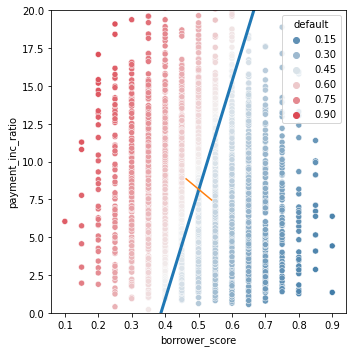

In [419]:
# Использовать scalings и центр средних для определения границы решения
center = np.mean(loan_lda.means_, axis=0) # центр
slope = -loan_lda.scalings_[0] / loan_lda.scalings_[1] # наклон
intercept = center[1] - center[0] * slope 

# Значение borrower_score при payment_inc_ratio = 0 и 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
print(lda_df.head())

fig, ax = plt.subplots(figsize=(5, 5))
g = sns.scatterplot(x = 'borrower_score', y = 'payment_inc_ratio',
                    hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=True)

ax.set_ylim(0,20)

ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()

__График оценочной вероятности__: точки данных слева от диагонали предсказываются как невыплата. Используя веса дискриминантной функции, линейный дискриминантный анализ разбивает предсказательное пространство на два участка. Предсказания, которые расположены дальше от линии (в обоих направлениях) имеют более высокий уровень доверия (т.е. вероятность намного дальше от 0.5)

__Линейный дискриминантный анализ__ работает также и более чем с 2 предикторами. Единственное ограничение - число записей (оценка матрицы ковариации требует достаточного числа записей на переменную, что в типичной ситуации не представляет проблему в приложениях науки о данных). Существуют и другие варианты дискриминантного анализа - cамым известным явл. квадратичный дискриминантный анализ (Quadratic Discriminant Analysis, QDA), несмотря на название явл. линейной функцией. Разница состоит в том, что в LDA матрица ковариаций принимается одинаковой для двух групп, соответствующих $Y=0$ и $Y=1$. А в QDA допускается, что матрица ковариаций может быть разной для двух групп, на практике эта разница не явл. критически важной.

* Дискриминантный анализ работает с непрерывными или категориальными предсказателями.
* Используя матрицу ковариаций, LDA вычисляет линейную дискриминантную функцию, которая используется для классификации записей.
* Эта функция применяется к записям для вычисления весов, или баллов, для каждой записи (один вес для каждого возможного класса), которые определяют к какому классу относится запись.

# Логистическая регрессия
Логистическая регрессия аналогична множественной линейной регрессии за одним исключением - исход явл. двоичным.

* __Логит (logit)__ - функция, которая отображает вероятность принадлежности классу в интервале $\pm\infty$ (вместо интервала от 0 до 1). 
* __Перевесы (odds)__ - отношение "успеха" (1) к "неуспеху" (0). Синонимы: шансы, фора, гандикап, преимущество.
* __Логарифм перевесов (log odds)__ - отклик в преобразованной модели (теперь линейный), котор. отображается назад в вероятность.

### Функция логистического отклика и логит
Ключевыми компонентами логистической регрессии явл. _функция логистического отклика_ и логит, в которых вероятность, находящаяся на шкале 0-1 отображается в вероятность на шкале $\pm\infty$, подходящую для линейного моделирования.

Первый шаг - думать о переменной исхода не как о двочиной метке, а как о вероятности _p_ того, что метка равна __1__. Может возникнуть соблазн наивно смоделировать _p_ как линейную функцию предсказательных переменных:

$$
    p=\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q
$$

Однако подгонка этой модели не обеспечит того, чтобы _p_ в итоге оказалась между 0 и 1, где должна быть вероятность.
Вместо этого, мы моделируем _p_ путем применения _логистического отклика_ или _обратного логита_ к предсказателям:

$$
    p=\frac{1}{1+e^{-(\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q)}}
$$

Указанное преобразование обеспечивает попадание вероятности в интервал 0-1. Для того чтобы извлечь экспоненциальное выражение из знаменателя, мы рассматриваем _шансы_(перевесы) вместо вероятностей.

__Шанс (odd)__ - вероятность события деленная на вероятность того что собтие не произойдет.

$$
    Шансы(Y=1)=\frac{p}{1-p}
$$

Можно расчитать вероятность из шансов:

$$
    p=\frac{Шансы}{1+Шансы}
$$

Комбинируя эту формулу с функцией логистического отклика, получаем:

$$
    Шансы(Y=1)=e^{\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q}
$$

Взяв логарифм выражений слева и справа от знака равенства, получается выражение, которое включает линейную функцию предсказателей:

$$
    log(Шансы(Y=1))=\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q
$$

Функция _логарифма шансов_ (логит функция) отображает вероятность _p_ из интервала (0, 1) в любое значение из интервала $\pm\infty$. Цикл преобразования завершен; была использована линейная модель для предскзаания вероятности, которую, в свою очередь, можно отобразить на метку класса путем применения правила отсечения - любая запись с вероятностью, превышающей порог отсечения, классифицируется как 1.

      p     logit      odds
0  0.01 -4.595120  0.010101
1  0.02 -3.891820  0.020408
2  0.03 -3.476099  0.030928
3  0.04 -3.178054  0.041667
4  0.05 -2.944439  0.052632


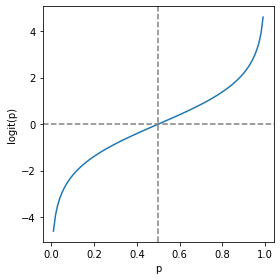

In [420]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p':p,
    'logit': np.log(p / (1-p)),
    'odds': p / (1-p)
})
print(df.head())
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(df['p'], df['logit'])
ax.axvline(0.5, color='grey', ls='--')
ax.axhline(0, color='grey', ls='--')

ax.set_xlabel('p')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()


График логит-функции, которая отображает вероятность в шкалу, подходящую для линейной модели.

### Логистическая регрессия и ОЛМ (обобщенные линейные модели)
Отклик в формуле логистической регресссии - это логарифм шансов двоичного исхода = 1. Мы наблюдаем только двоичный исход, а не логарифм перевесов, и поэтому для подгонки уравнения требуются специальные статистические методы. 

Логистическая регрессия явл. частным случаем _обобщенной линейной модели_ (generalized linear model, GLM), разработанной для расширения линейной регрессии.
Следующий фрагемнт кода выполняет подгонку логистической регрессии к данным о персональных ссудах. 

В _Python_ мы используем класс `LogisticRegression` из модуля `sklearn.linear_model`. Аргументы `penalty` и `С` применяются для предотвращения переподгонки регуляризацией __L1__ и __L2__. Регуляризация включена по умолчанию. Для того, чтобы выполнить переподгонку без регуляризации, мы устанавливаем `С` равным очень большому значению. Аргумент `solver` выбирает используемый минимизатор; по умолчанию  используется метод 'lbfgs'.

In [421]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 
              'emp_len_', 'borrower_score']
outcome = 'outcome'


X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                  drop_first=True)
y = loan_data['outcome']


logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print(f'Intercept: {logit_reg.intercept_[0]}')
print(f'classes: {logit_reg.classes_}')
pd.DataFrame({'coeff':logit_reg.coef_[0]}, index=X.columns)

Intercept: -1.6378908649112442
classes: ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


Пересчение и большинство коэффициентов отрицательны и если поменять порядок вывода классов переменной отклика Y ('default' и 'paid off'), который по умолчанию осуществляется в алфафитном порядке, __мы получим неинвертированные значения__.
Для изменения порядка значений категориальной переменной, можно использовать метод `OrdinalEncoder` из пакета _scikit-learn_ для того чтобы заменить категории (здесь 'default' и 'paid off') на соответствующие числовые значения. В следующем коде происходит замена значения 'paid off' на 0 и 'default' на 1. Таким образом изменяется порядок вывода классов и как следствие коэффициенты будут обратными:

In [422]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print(f'Intercept: {logit_reg_enc.intercept_[0]}')
print(f'output classes: {logit_reg_enc.classes_}')
print('Predictor classes:')
print(f"purpose_: {[i for i in loan_data['purpose_'].cat.categories]}")
print(f"home_: {[i for i in loan_data['home_'].cat.categories]}")
print(f"emp_len_: {[i for i in loan_data['emp_len_'].cat.categories]}")
pd.DataFrame({'coeff':logit_reg_enc.coef_[0]}, index=X.columns)

Intercept: 1.6380885430318344
output classes: [0. 1.]
Predictor classes:
purpose_: ['credit_card', 'debt_consolidation', 'home_improvement', 'major_purchase', 'medical', 'other', 'small_business']
home_: ['MORTGAGE', 'OWN', 'RENT']
emp_len_: [' < 1 Year', ' > 1 Year']


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


__Полученные коэффициенты являются относительными. Т.е. для переменной `purpose_` все значения коэффициентов расчитаны
относительно значения `credit_card` и т.д.__

### Обобщенные линейные модели
Обобщенные линейные модели (ОЛМ, Generalized Linear Model, GLM) характеризуется двумя главными компонентами:
* вероятностным распределением или семейством (биномиальным в случае логистической регрессии)
* функцией связи, т.е. функцией преобразования, которая отображает отклик в предсказатели (логит в случае логистической регрессии)

Логистическая регрессия, безусловно, является наиболее часто встречающейся формой ОЛМ. Исследователь данных будет сталкиваться и с другими ОЛМ. Иногда вместо логита используется логарифм функции связи; на практике применение логарифма функции связи вряд ли приведет к сильно отличающимся результатам для большинства приложений.

### Предсказанные значения из логистической регрессии.
Предсказанное значение из логистической регрессии, рассматривается с точки зрения логарифма перевесов:
$$
 \hat{Y}=log(Шансы(Y=1))
$$
Предсказанная вероятность задается функцией логистического отклика:
$$
 \hat{p}=\frac{1}{1+e^{-\hat{Y}}}
$$
Посмотрим на предсказанные значения из модели _logit_reg_. В _Python_ мы можем конвертировать вероятности в _dataframe_ и использовать метод _decribe()_, чтобы получить характеристики распределения:

In [423]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                   columns=loan_data[outcome].cat.categories)

pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,-0.757872,-0.760434
std,0.378093,0.390456
min,-2.769376,-3.538593
25%,-0.985739,-0.977207
50%,-0.697406,-0.688907
75%,-0.472183,-0.467069
max,-0.029485,-0.064753


Вероятности можно вычислить при помощи метода `predict_proba()` пакета _scikit-learn_:

In [424]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                   columns=loan_data['outcome'].cat.categories)
pred

,default,paid off
0,0.242505,0.757495
1,0.314114,0.685886
2,0.516650,0.483350
3,0.588009,0.411991
4,0.458639,0.541361
...,...,...
45337,0.547161,0.452839
45338,0.462878,0.537122
45339,0.447686,0.552314
45340,0.278304,0.721696


Эти значения вероятности находятся на шкале от 0 до 1 и еще не объявляют о том, имеет ли предсказание значение "default" или "paid off"

### Интерперетирование коэффициентов и отношение шансов
Преимущество логистической регрессии состоит в том, что она порождает модель, которую ускоренно можно применять для задания баллов новым данным без повторного вычисления. Еще одно преимущество - относительная простота интерпретации модели по сравнению с другими классификационными методами. Ключевая идея заключается в понимании _отношения перевесов_, или _шансов_. Отношение перевесов легче всего понять для двоичной факторной переменной X:
$$
отношение-шансов = \frac{Шансы(Y=1|X=1)}{Шансы(Y=1)|(X=0)}
$$
Указанная формула интерпретируется как шансы того, что Y=1 при X=1, против шансов того, что Y=1 при X=0. Если отношение перевесов равно 2, то шансы того, что Y=1, будут в два раза выше, когда X=1, чем когда X=0.

Мы работаем с шансами (вместо вероятностей) потому что коэффициент $\beta_j$ в логистической регрессии явл. логарифмом отношения щансов для $X_j$.
Пример: для ранее подогнанной модели `logit_reg_enc`, коэффициент регрессии для переменной `purpose_small_business` равен 1.215662. Он означает, что заём малому бизнесу в сравнении с заёмом для погашения кредитной карты, уменьшает шансы невыплаты ('default') против шансов погашения ('paid off') на exp(1.215662) = 3.4. Безусловно, кредиты в целях создания или расширения малого бизнеса значительно рискованнее других типов кредитов.

Ниже приведен код, который строит график который отражает связь между _отношением шансов_ и _отношением лоагрифма шансов_ для _отношения шансов_ > 1. Поскольку коэффициенты находятся на логарифмической шкале, увеличение на 1 в коэффициентах приводит к увеличению на exp(1)=2.72 в _отношении шансов_

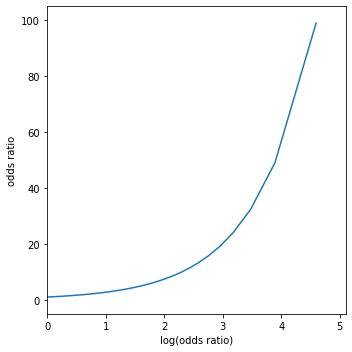

In [425]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5,105)

plt.tight_layout()
plt.show()

Отношения шансов для числовых переменных X можно проинтерпретировать схожим образом: они измеряют изменение в отношении шансов для единичного изменения в X. Например, эффект  от увеличения отношения платежей к доходам (payment-to-income ratio), скажем с 5 до 6 увеличивает шанс невыплаты кредита в exp(0.079728) = 1.08 раз. Переменная `borrower_score` - это балл кредитоспособности заемщиков от 0 (низкий) до 1 (высокий). Шанс невылпаты кредита лучших заемщиков относительно худших, меньше в exp(-4.611037) = 0.01 раз. Другими словами, риск невыплаты от заемщиклв с самой слабой кредитоспособностью в 100 раз больше, чем риск невыплаты у самых лучших заемщиков!

### Линейная и логистическая регрессия: 
#### Cходства и различия
Имеют много схожиж черт: обе принимают параметрическую линейную форму, увязывающую предсказатели с откликом. Разведывание и отыскание лучшей модели выполняется очень похоже. Расширения линейной модели, такие как сплайновые преобразования предикторов одинаковым образом применимы в логистической регрессионной формулировке.
Однако, есть 2 фундаментальных отличия:
* характер выполнения подгонки модели (наименьшие квадраты не применимы)
* природа и анализ остатков модели.

#### Подгонка модели
Подгонка линейной регрессии осуществляется за счет метода наименьших квадратов, а качество подгонки оценивается при помощи метрик RMSE и $R^2$.
В логистической регрессии (в отличие от линейной) подгонка модели осуществляется методом _оценки максимального правдоподобия_ (Maximum Liklihood Estimation, MLE).  Оценка максимального правдоподобия - это процедура, пытающаяся отыскать модель, вероятнее всего породившую данные, которые мы видим. В уравнении логистической регрессии откликом явл. не 0 или 1, а оценка логарифма перевесов о том, что отклик равняется 1. Оценка максимального правдоподобия отыскивает такое решение, что оценочный логарифм перевесов наилучшим образом описывает наблюдаемый исход. 

#### Метод максимального правдоподобия
Есть набор данных $(X_1, X_2, ..., X_n)$ и вероятностная модель $P_{\theta}(X_1, X_2, ..., X_n)$, которая зависит от наборов параметров $\theta$. Цель оценки максимального правдоподобия, состоит в том, чтобы отыскать набор параметров $\hat{\theta}$, который максимизирует значение $P_{\theta}(X_1, X_2, ..., X_n)$, т.е. максимизирует вероятность наблюдать $(X_1, X_2, ..., X_n)$ при наличии модели __P__.
В процессе подгонки модель оценивается при помощи метрики, которая называется девиантностью.

$$
    погрешность = -2log(P_{\theta}(X_1, X_2, ..., X_n))
$$

Более низкая девиантность соответствует более хорошей подгонке.

#### Работа с факторными переменными
В логистической регрессии факторные переменные также должны кодироваться в числовые значения как и в линейной регрессии.

#### Оценка результаттивности модели
Как и другие классификационные методы, логистическая регрессия оценивается тем, насколько точно модель классифицирует новые данные. Как и в случае с линейной регрессией, имеется несколько стандартных статистических инструментов. Пакет `statsmodels` имеет имплементацию для обобщенной линейной модели (GLM), которая сообщает о стандартной ошибке коэффициентов, z-оценке и p-значении.
Для сравнения, здесь создается модель GLM с использованием statsmodels. Этот метод требует, чтобы результат (переменная отклика) сопоставлялся с числами.

In [426]:
y_numbers = [1 if yi == 'default' else 0 for yi in y] # y = loan_data['outcome']
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), # X = pd.get_dummies(loan_data[predictors]...)
                     family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Sun, 03 Jul 2022   Deviance:                       57515.
Time:                        16:39:34   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

* Интерпретация p-значения сопровождается теми же оговорками, что и в регрессии, и должна рассматриваться больше как относительный индикатор важности переменной, чем как формальная мера статистической значимости. 

* С логистической линейной регрессией, которая имеет двоичный отклик, не связан ни показатель RMSE, ни R-квадрат. Вместо этого логистическая регрессионная модель оценивается при помощи более общих метрик, используемых для классификации (далее в этой теме).

* Многие другие понятия регрессии переносятся на логистическую регрессию (и другие ОЛМ). Например, можно применить пошаговую регрессию или включить сплайновые члены. Тоже самое касается искажающих и коррелированных переменных. 

* Также, можно выполнить подгонку обобщенных аддитивных моделей:

In [430]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ +' +
          'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Sun, 03 Jul 2022   Deviance:                       57462.
Time:                                               16:56:11   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                      

Часть результатов метода `summary` можно проигнорировать. Параметр дисперсии не применяется к логистической регрессии и находится там для других типов ОЛМ. Остаточная погрешность и число итераций количественного оценивания связаны с оценкой максимального правдоподобия.

### Анализ остатков
Одна область, в которой логистическая регрессия отличается от линейной регрессии - анализ остатков.

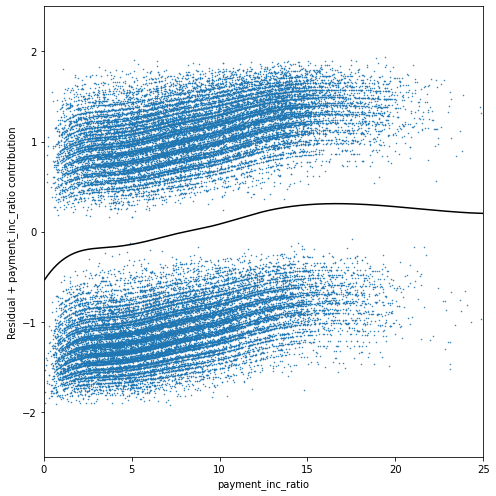

In [431]:
from statsmodels.genmod.generalized_linear_model import GLMResults

def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(7, 7))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

Оценочная подгонка, показанная линией, проходит между двумя наборами точечных облаков. Верхнее облако соответствует отклику 1 (невыплаченные ссуды) и нижнее облако - отклику 0 (погашенные ссуды). Такой вид очень типичен для остатков от логистической регрессии, поскольку выходные данные являются двоичными. Предсказание измеряется как логит (логарифм отношения шансов), который всегда будет иметь некоторое конечное значение. Фактическое значение, абсолютное 0 или 1, соответствует бесконечному логиту, положительному или отрицательному, поэтому остатки, которые добавляются к подогнанному значению) никогда не будут равны 0. Следовательно, нанесенные точки лежат в облаках выше либо ниже подогнанной прямой на графике частных остатков. Частные остатки в логистической регрессии, хотя и менее ценны, чем в регрессии, все же полезны для подтверждения нелинейного поведения и выявления весьма влиятельных записей.

### Ключевые идеи для логистической регрессии
* Логистическая регрессия похожа на линейную регрессию, за исключением того, что откликом является двоичная переменная.
* Для приведения модели к линейной форме, нужно выполнить несколько преобразований, при этом логарифм отношения шансов выступает в качестве переменной отклика.
* После подгонки модели (путем итеративного процесса) логарифм шансов отображается обратно в вероятность.
* Логисчтическая регрессия явл. популярной по причине своего вычислительного быстродействия, а также она пораждает модель, которую можно применять для задания баллов новым данным с помощью малого числа ариметических операций.

## Оценка классификационных моделей

В предсказательном моделировании общепринято тренировать большое число разных моделей, применять каждую к отложенной выборке и оценивать их работоспособность.

__Точночсть (accuracy)__ - процент (доля) случаев, классифицированных правильно;<br>
__Матрица ошибок (confusion matrix)__ - таблица, отображающая кол-во записей по их предсказанному значению и фактическому;<br>
__Чувствительность (sensivity)__ - процент (доля) всех единиц, правильно классифицированных как единицы;<br>
__Специфичность (specificity)__ - процент (доля) всех нулей, правильно классифицированных как нули;<br> 
__ROC-кривая (ROC curve)__ - график чувствительности против специфичности;<br>
__Лифт (lift)__ - мера эффективности модели и идентификации (сравнительно редких) единиц при разных порогах вероятности.<br>

Простой способ измерить результативнность классификации - посчитать долю правильных предсказаний, т.е. меру точности. Точность - это просто суммарная ошибка.
$$
    Точность = \frac{\sum_{истинноположит.} + \sum_{истинноотрицат.}}{N}
$$


### Матрица ошибок (confusion matrix)
Одной из основных классификационных метрик явл. матрица ошибок - это таблица, показывающая число правильных и неправильных предсказаний, сгруппированных по типу отклика. В __Python__ есть множество средст для ее леализации, но для двичного отклика, матрицу легко построить вручную.

Пусть имеется модель `logit_reg`, которая была натренирована на сбалансированном наборе данных с равным числом невыплаченных и погашенных ссуд. Следуя принятым правилам,  $Y=1$ соответствует интересующему событию (например, невыплата) и $Y=0$ соответствует отрицательному (либо обычному) событию (например, погашено). Следующий фрагмент кода вычисляет `confusion matrix` для модели `logit_reg`, примененной __ко всему (несбалансированному)__ тренировочному набору:

In [452]:
pred = logit_reg.predict(X)  # X = pd.get_dummies(loan_data[predictors]...)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default' # y = loan_data['outcome']
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)],
                        [np.sum(false_pos), np.sum(true_neg)]],
                       index=['y = default', 'y = paid off'],
                       columns=[r'$\hat{y}$ = default', r'$\hat{y}$ = paid off'])
                                
conf_mat

,$\hat{y}$ = default,$\hat{y}$ = paid off
y = default,14337,8334
y = paid off,8149,14522


Предсказанными исходами явл. столбцы, а истинными - строки. Числа на главной диагонали - кол-во правильных предсказаний, числа вне - кол-во неправильных.
Одна из важных метрик - `интенсивность ложноположительных исходов` (зерклаьное отражение прецизионности). Когда единицы встречаются редко (в данных), отношение ложноположительных исходов ко всем предсказанным положительным исходам может быть высоким, приводя к нелогичной ситуации когда предсказанная 1 скорее всего является 0. Эта частая проблема для диагностических тестов при медицинских обследованиях.

### Прецизионность, полнота и специфичность
__Прецизионность__ измеряет точность предсказанного положительного исхода:

$$
    Прецизионность = \frac{\sumИП}{\sumИП + \sumЛП}
$$

__ИП__ - истинноположительный<br>
__ЛП__ - ложноположительный<br>

__Полнота__, также именуемая чувствительностью, измеряет силу модели в предсказании положительного исхода - доля единица, которые она правильно идентифицирует.Термин "чувствительность" часто применяется в биостатистике и медецине, тогда как "полнота" больше применяется в сообществе машинного обучения.

$$
    Полнота = \frac{\sumИП}{\sumИП + \sumЛО}
$$

__ИП__ - истинноположительный<br>
__ЛП__ - ложноотрицательный<br>

__Специфичность__ - метрика, которая измеряет способность модели предсказывать отрицательный исход

$$
    Полнота = \frac{\sumИО}{\sumИО + \sumЛО}
$$

__ИО__ - истинноотрицательный<br>
__ЛП__ - ложноотрицательный<br>

The _scikit-learn_ function `precision_recall_fscore_support` returns
precision, recall, fbeta_score and support. 

In [459]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))

print(f'Прецизионность = {conf_mat[0, 0] / sum(conf_mat[:, 0])}')
print(f'Полнота = {conf_mat[0, 0] / sum(conf_mat[0, :])}')
print(f'Специфичность = {conf_mat[1, 1] / sum(conf_mat[1, :])}')

Прецизионность = 0.6375967268522637
Полнота = 0.6323938070662961
Специфичность = 0.640554011733051


Пакет _scikit-learn_ имеет метод `precision_recall_fscore_support`, который расчитывает прецизионность, полноту и специфичность:

In [460]:
precision_recall_fscore_support(y, logit_reg.predict(X),
                               labels = ['default', 'paid off'])

(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671]))

### ROC - кривая
ROC - кривая ("receiver operating characteristics"). Впервые была использована во время Второй мировой войны для описания результаттивности радарных приемных станций, работа которых состояла в том, чтобы правильно идентифицировать отраженные радарные сигналы и предупреждать силы обороны о приближающемся самолете. ROC-кривая наносит полноту на ось Y и специфичность на ось X и показывает отношение между полнотой и специфичностью по мере изменяемого (нами) порога отсечения, чтобы определить каким образом классифицировать запись.
Встречаются 2 типа обозначений на оси X:
* 1 слева и 0 справа<br>
* 0 слева и 1 справа<br>

Кривая выглядит идентичной независимо от обозначений.
Процесс вычисления ROC-кривой:

1) Отсортировать записи по предсказанной вероятности быть единицей, начиная с наиболее вероятной и заканчивая наименее вероятной;
1) Вычислить кумулятивную специфичность и полноту, основываясь на сортированных записях.

Существует метод `skleran.metrics.roc_curve` для вычисения информации. необходимой для построения ROC-кривой

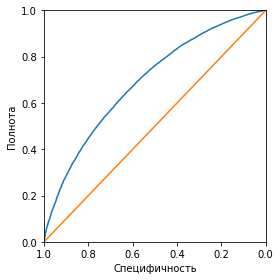

In [464]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                                pos_label='default')
roc_df = pd.DataFrame({'recall' : tpr, 'specificity' : 1-fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('Специфичность')
ax.set_ylabel('Полнота')

plt.tight_layout()
plt.show()

Оранжевая диагональная линия соответствует классификатору, который не лучше случайности. Черезвычайно эффективный классификатор будет иметь ROC-кривую, которая прижимается к левому верхнему углу, - она правильно идентифицирует много единиц без неправильной классификации многих нулей вместо единиц. Если для этой можели нам нужен классификатор со специфичностью по крайней мере 50%, то полнота составит примерно 75%.

В дополнение к ROC-кривым м.б. полезным обследовать кривую прецизионности-полноты, или PR-кривую (precision-recall). PR-кривые в особенности полезны в оценивании данных с очень несбалансированными исходами. Вычисляются они схожим образом, за исключением того, что данные упорядочены от наименьшей вероятности до наибольшей и вычисляются кумулятивные статисики прецизионности и полноты. 

### Площадь под ROC-кривой AUC( area under the ROC-curve)
Метрика __AUC__- площадь под ROC-кривой. Чем больше значение AUC, тем эффективнее классификатор. Если AUC=1, то классификатор идеальный: он правильно идентифицирует все 1 и не идентифицирует (неправильно) любые нули как единицы.
Совершенно неэффективный классификатор - диагональная прямая - будет иметь AUC=0.5.


Точность может быть легко расчитана при помощи метода `accuracy_score`библиотеки `sklearn`.

In [470]:
print(np.sum(roc_df.recall[:-1] * np.diff(1-roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:,0]))

0.6917107174637571
0.691710795288669


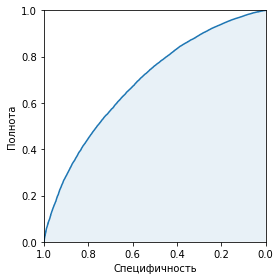

In [473]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                                pos_label='default')
roc_df = pd.DataFrame({'recall' : tpr, 'specificity' : 1-fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.set_xlabel('Специфичность')
ax.set_ylabel('Полнота')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.1)

plt.tight_layout()
plt.show()

Модель имеет AUC = 0.69 что соответствует относительно слабому классификатору.

### Лифт
Применение метрики AUC для оценки модели лучше, чем использование просто точности, т.к. AUC позволяет оценить насколько хорошо классификатор справляется с компромиссом между общей точностью и и потребностью идентифицировать важные единицы. Однако AUC не полностью решает проблему редкого класса, когда необходимо понизить вероятностный порог отсечения в модели ниже 0.5, во избежания идентификации всех записей как 0. В таких случаях, чтобы идентифицировать запись как единицу, будет достаточно иметь вероятность 0.4, 0.3 или ниже. В результате мы приходим к тому, что сверхидентифицируем единицы, отражая их большую важность (за счет неправильной классификации нулей как единицы).
Изменение порга отсечения повысит шансы улавливать единицы, но какой порог отсечения является оптимальным? 

Понятие __лифт__ позволяет отложить ответ на этот вопрос в сторону. Вместо этого мы рассматриваем записи в порядке их предсказанной вероятности быть единицами. Скажем если взять 10% верхних записей такого списка, насколько лучше рабоатает алгоритм по сравнению с выбором в слепую? Если мы можем получить 0.3% отклик в этом верхнем дециле, вместо 0.1%-го который получается по совокупности, выбирая случайным образом, то говорят что алгоритм имеет лифт равный 3 в верхнем дециле.

Для того чтобы построить __график лифта__, сначала строят график кумулятивного прироста, откладывая на оси X - суммарное число записей, а на оси Y полноту.<br>
__Кривая лифта__ - это отношение кумулятивного прироста к диагональной прямой, соответствующей случайному выбору. Кривая лифта позволяет посмотреть на последствия установки разных отсечений вероятности для классифицирования записей как единиц. Например, налоговая может иметь лишь ограниченный объем ресурсов на налоговоые аудиты и хочет потратить их на наиболее вероятные случаи налогового мошенничества. Учитывая ораничение по ресурсам, руководство пользуется графиком лифта для оцнки того, где нужно прочертить прямую между налоговомы декларациями, отобранными для аудиты и теми, которые были оставлены в покое.<br>

### Стратегии для несбалансированных данных
### Понижающий отбор (undersampling)
Если данных достаточно, как в случае с данными о заемах, одно из решений состоит в понижающем отборе преобладающего класса, чтобы моделируемые данные были сбалансированнее между нулями и единицами. Базовая идея состоит в том, что данные для доминирующего класса имеют много избыточных записей. Работа с меньшим, более сбалансированным набором дает выгоды в результативности модели, упрощает подгонку данных, а также дальнейшую работу с моделью. Данные о заемах, проанализированные в разделе "Логистическая регрессия", были основаны на сбалансированном тренировочном наборе: половина заемов была погашена, другая половина - нет. В полном наборе данных не было выплачено всего примерно 19% заёмов.

In [498]:
print('Сбалансированные данные из раздела "Логистическая регрессия"')
print(f"Процент невыплаченных заемов: {100 * np.mean(loan_data.outcome == 'default')}%")
print(f"Процент выплаченных заемов: {100 * np.mean(loan_data.outcome == 'paid off')}%")

Сбалансированные данные из раздела "Логистическая регрессия"
Процент невыплаченных заемов: 50.0%
Процент выплаченных заемов: 50.0%


In [507]:
full_train_set = pd.read_csv('/Users/ivankudravcev/Studying/Data/full_train_set.csv')
full_train_set.shape

(119987, 19)

In [511]:
print('Все данные')
print(f"Процент невыплаченных заемов: {100 * np.mean(full_train_set.outcome == 'default'):.2f} %")
print(f"Процент выплаченных заемов: {100 * np.mean(full_train_set.outcome == 'paid off'):.2f} %")

Все данные
Процент невыплаченных заемов: 18.89 %
Процент выплаченных заемов: 81.11 %


Что произойдет если натренировать модель на полном объеме данных?

In [550]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_',
             'emp_len_', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

X = pd.get_dummies(full_train_set[predictors], drop_first=True,
                  prefix='', prefix_sep='')
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)

print("Процент заемов предсказанных как невыплаченные: " +
      f"{100 * np.mean(full_model.predict(X) == 'default'):.2f} %")

Процент заемов предсказанных как невыплаченные: 0.15 %


Только 0.15% заемов были предсказаны как невыплаченные, в отличие от ожидаемых 19%
Погашенные заемы подавляют количеством невыплаченные.

###  Повышающий отбор и повышающая/понижающая перевесовка
Один из критических недостатков понижающего отбора - этот метод не использует всю имеющуюся информацию. Если набор данных небольшой то понижение доминирующего класса несет риск выкинуть полезную информацию. В этом случае вместо понижения доминирующего класса, можно воспользоваться повышением редкого класса путем извлечения дополнительных строк с возвратом (бутсрапирование). Можно добиться похожего эффекта путем взвешивания данных. Многие классификационные алгоритмы принимают аргумент веса. 

Большинство методов пакета scikit-iearn позволяют задавать веса в методе `fit()` с помощью аргумента `sample weight`:

In [561]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 
      for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y, wt)

print("Процент заемов предсказанных как невыплаченные: " +
      f"{100 * np.mean(full_model.predict(X) == 'default'):.2f} %")

Процент заемов предсказанных как невыплаченные: 61.80 %


Вес для невыплаченных заемов установили $1/p$, где __p__ - это вероятность невыплаты. Выплаченны заемы имеют вес __1__. Взвешивание обеспечивает альтернативу как для повышения отбор редкого класса, так и для понижения отбора доминирующего.

### Генерация данных
Идея состоит в создании новых записей, которые похожи, но не идентичны существующим записям.
Указанная идея набрала обороты с публикацией алгоритма __SMOTE__ (synthetic minority oversampling technique). Алгоритм SMOTE находит запись, которая похожа на запись, подвергаемую повышающему отбору и создает синтетическую запись, которая является случайно средневзвешенным исходной записи и соседней записи (соседние записи определяются методом k-ближайших соседей), где вес генерируется отдельно для каждого предсказателя. Число синтетических записей, взятых повышающим отбором, зависит от коэффициента повышающего отбора, который требуется для приведения набора данных в приближенное равновесие относительно классов исхода.<br>
Библиотека _imbalanced-learn_ содержит имплементацию алгоритма _SMOTE_ и дургих похожих. 

In [566]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('процент невыплаченных заемов (SMOTE resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('процент предсказанных невыплаченных заемов (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('процент невыплаченных заемов (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('процент предсказанных невыплаченных заемов (ADASYN): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

процент невыплаченных заемов (SMOTE resampled):  50.0
процент предсказанных невыплаченных заемов (SMOTE):  29.465692116645968
процент невыплаченных заемов (ADASYN resampled):  48.56040383751355
процент предсказанных невыплаченных заемов (ADASYN):  27.401301807695834


### Исследование предсказаний

In [568]:
loan3000 = pd.read_csv('/Users/ivankudravcev/Studying/Data/loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


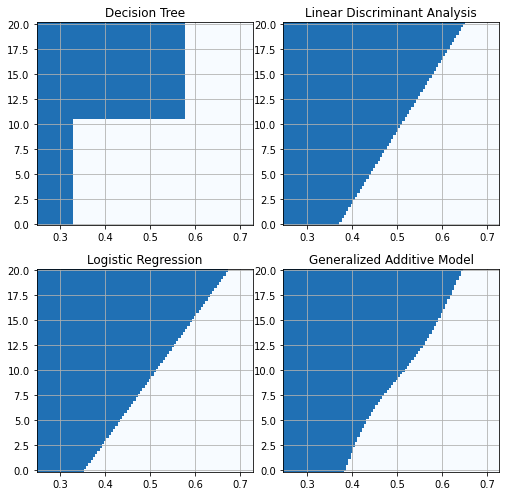

In [573]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = pd.DataFrame({
    'borrower_score': xx.ravel(),
    'payment_inc_ratio': yy.ravel(),
})

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

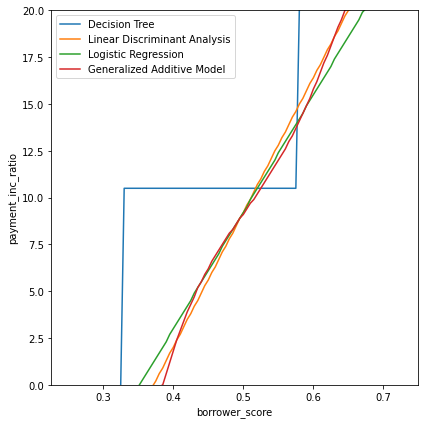

In [572]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(6, 6))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)


plt.tight_layout()
plt.show()